In [ ]:
# Для работы с html файлами
from bs4 import BeautifulSoup

# Для работы с таблицами
import pandas as pd

# Для работы со смайликами в тексте
import emoji

# Для превращения смайликов в слова
import demoji

# pip install googletrans==3.1.0a0
# Переводчик
from googletrans import Translator

# Для VK
from vk_api import VkApi

import json

ModuleNotFoundError: No module named 'emoji'

https://dev-gang.ru/article/perevod-teksta-s-pomosczu-google-translate-api-v-python-ahgm88wx1k/

# Парсинг вконтакте


In [64]:
import vk_api

In [3]:
# Вставьте сюда свой access_token, полученный из адресной строки!
# vk1.a.cPo9dt5bWCZbbkHqA8qiOmaly13S0rDKB91SKF8IyZIsSKlaNSjB8SEOCL4SSeeaJXkgy-Q6UrbSyxOZGZl8Mbx1Qf95X2Ppbv1RBgg5HhxDk-V4SVJD4L9NtbQQpqQ8rpy_mGw6ctdlLoBtd9klDnRjzj5sSP4oXw8k0AyALEwNNHw6BnDrbM3V_57_EGS3wWqyoTCD6ylTPkptJP_fMg


token='vk1.a.cPo9dt5bWCZbbkHqA8qiOmaly13S0rDKB91SKF8IyZIsSKlaNSjB8SEOCL4SSeeaJXkgy-Q6UrbSyxOZGZl8Mbx1Qf95X2Ppbv1RBgg5HhxDk-V4SVJD4L9NtbQQpqQ8rpy_mGw6ctdlLoBtd9klDnRjzj5sSP4oXw8k0AyALEwNNHw6BnDrbM3V_57_EGS3wWqyoTCD6ylTPkptJP_fMg'

In [ ]:
def main(offset: int, token: str, group_id: str, count: int):
    vk = vk_api.VkApi(token=token)
    api = vk.get_api()
    
    # Получаем числовой ID группы
    group_info = api.groups.getById(group_id=group_id)
    numeric_group_id = -group_info[0]['id']
    
    # Получаем посты
    posts = api.wall.get(owner_id=numeric_group_id, offset=offset, count=count)['items']
    
    posts_strings = []
    # num_like = []
    comments_data = []
    
    for post in posts:
        posts_strings.append(post['text'])
        
        try:
            # Получаем комментарии с информацией об авторах
            comments_response = api.wall.getComments(
                owner_id=numeric_group_id, 
                post_id=post['id'], 
                count=100,
                extended=1  # Добавляем информацию о пользователях
            )
            
            comments_items = comments_response['items']
            
            # Собираем данные комментариев с метаданными
            post_comments_data = []
            for comment in comments_items:
                comment_data = {
                    "text": comment.get('text', ''),
                    "metadata": {
                        "group_id": group_id,
                        "author_id": comment.get('from_id', '')
                    }
                }
                post_comments_data.append(comment_data)
            
            comments_data.append(post_comments_data)
            
        except Exception as e:
            print(f"Ошибка при получении комментариев: {e}")
            comments_data.append([])
    
    return posts_strings, comments_data

## Начало проекта: анализ тональности комментариев о метро

Проект реализован в рамках задачи классификации тональности пользовательских отзывов о метрополитене.

## Сбор данных

Для обучения модели собрано 7500 комментариев из 300 постов.
Для обеспечения разнообразия данных и репрезентативности выборки комментарии были собраны из трёх тематических сообществ:

- **Подслушано Метро Москвы** (ID: 'pmmgo')
- **Московское метро** (ID: 'mosmetro') 
- **Мир метро** (ID: 'mirmetro')

Из каждого сообщества отобрано по 100 постов для равномерного распределения данных.

In [ ]:
all_comments_data = []

for group_name in ['pmmgo', 'mosmetro', 'mirmetro']:
    
    for i in range(100, 401, 100):
        print(f"Обработка группы: {group_name} На сотке: {i}")
    
        # Оффсет ставим 1, на случай рекламных постов в начале
        if group_name == 'pmmgo' and i==400:
            continue
        else:
            rzd_posts, comments_data_rzd = main(offset=i, token=token, group_id=group_name, count=100)

        for post_comments in comments_data_rzd:
            all_comments_data.extend(post_comments)
        

print(f"\nВсего комментов: {len(all_comments_data)}")

Обработка группы: pmmgo На сотке: 100
Обработка группы: pmmgo На сотке: 200
Обработка группы: pmmgo На сотке: 300
Обработка группы: pmmgo На сотке: 400
Обработка группы: mosmetro На сотке: 100
Обработка группы: mosmetro На сотке: 200
Обработка группы: mosmetro На сотке: 300
Обработка группы: mosmetro На сотке: 400
Обработка группы: mirmetro На сотке: 100
Обработка группы: mirmetro На сотке: 200
Обработка группы: mirmetro На сотке: 300
Обработка группы: mirmetro На сотке: 400

Всего комментов: 14262


In [ ]:
with open('data/vk_comments.json', 'w', encoding='utf-8') as f:
    json.dump(all_comments_data, f, ensure_ascii=False, indent=2)

print("Данные сохранены")

Данные сохранены


In [68]:
with open('data/vk_comments.json', 'r', encoding='utf-8') as f:
    loaded_data = json.load(f)

for i, comment in enumerate(loaded_data[:3], 1):
    print(f"\nКомментарий {i}:")
    print(f"  Текст: {comment['text'][:100]}...")
    print(f"  Группа: {comment['metadata']['group_id']}")
    print(f"  Автор: {comment['metadata']['author_id']}")


Комментарий 1:
  Текст: ...
  Группа: pmmgo
  Автор: 43734673

Комментарий 2:
  Текст: Где то Джерри хулюганит😁...
  Группа: pmmgo
  Автор: 863821330

Комментарий 3:
  Текст: Милый рыжик!...
  Группа: pmmgo
  Автор: 27551408


## Метаданные

В финальный датасет вошло около 7000 комментариев. Для каждого комментаря сохранены следующие метаданные:

- **group_id** — идентификатор сообщества-источника
- **is_frequent_poster** — бинарный признак активности автора (1 — ≥ 5 комментариев, 0 — < 5 комментариев)

Показатель активности автора выбран как индикатор релевантности пользовательского мнения.

In [69]:
from collections import Counter

In [70]:
author_counts = Counter()
for comment in loaded_data:
    author_id = comment['metadata']['author_id']
    author_counts[author_id] += 1

In [71]:
author_counts

Counter({840964348: 178,
         349012778: 128,
         695761943: 112,
         390450495: 91,
         88470611: 72,
         0: 65,
         11062102: 61,
         2701352: 57,
         27551408: 53,
         73009045: 53,
         147227048: 49,
         720604978: 47,
         852529207: 42,
         3664400: 42,
         2173273: 40,
         510403005: 39,
         251128063: 36,
         597562095: 33,
         35884108: 32,
         567177772: 31,
         585098696: 29,
         2281437: 28,
         634772283: 28,
         7696068: 27,
         707288346: 26,
         893644094: 25,
         225979593: 25,
         896915470: 25,
         829288931: 23,
         658307126: 23,
         204935776: 22,
         863821330: 21,
         1057997148: 21,
         447607869: 21,
         268307812: 21,
         31356699: 21,
         736255968: 21,
         391886190: 20,
         236105994: 20,
         639716916: 20,
         248834296: 19,
         69753777: 19,
         4303

In [72]:
# Считаем авторов с >10 комментариями
authors_more_than_10 = sum(1 for count in author_counts.values() if count >= 10)
authors_more_than_5 = sum(1 for count in author_counts.values() if count >= 5)
total_authors = len(author_counts)

# Процент
print(f"Процент авторов у которых >= 10: {authors_more_than_10 / total_authors}")
print(f"Процент авторов у которых >= 5: {authors_more_than_5 / total_authors}")

Процент авторов у которых >= 10: 0.02904830685283261
Процент авторов у которых >= 5: 0.09083614187128872


## Статистика активности авторов

Анализ распределения авторов по количеству комментариев:

- Авторы с ≥10 комментариями: 3% от общего числа
- Авторы с 5 комментариями: 9% от общего числа

Установлен порог в 5 комментариев для признака активности автора. 
Авторы с меньшим количеством комментариев исключены из анализа, 
поскольку их активность может быть ограничена обсуждением одного поста 
и не является показателем систематической вовлечённости.

In [73]:
for comment in loaded_data:
    author_id = comment['metadata']['author_id']
    
    # Если автор оставил >= 5 комментариев, ставим 1, иначе 0
    is_frequent = 1 if author_counts[author_id] >= 5 else 0
    comment['metadata']['is_frequent_poster'] = is_frequent

In [74]:
with open('data/vk_comments_with_metadata.json', 'w', encoding='utf-8') as f:
    json.dump(loaded_data, f, ensure_ascii=False, indent=2)

## Предобработка текста

Для моделей на архитектуре BERT применён следующий пайплайн предобработки:

- **Сохранено**: лемматизация, стоп-слова и пунктуация не удаляются, 
  так как BERT использует subword tokenization и обучается на полных контекстах

- **Выполнено**: 
  * Очистка от HTML-тегов и технических артефактов
  * Преобразование эмодзи в текстовые описания
  * Нормализация специализированной терминологии (например, "мцк" → "московское центральное кольцо")

In [75]:
import json
import re
import html
from typing import List, Dict
import unicodedata

In [76]:
def clean_html(text: str) -> str:
    
    # HTML
    if not text:
        return ""
    
    # Декодируем HTML (&amp; → &)
    text = html.unescape(text)
    
    # Удаляем HTML-теги
    text = re.sub(r'<[^>]+>', ' ', text)
    return text

def remove_urls_and_emails(text: str) -> str:

    # URL
    text = re.sub(
        r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
        ' [URL] ',
        text
    )
    # www-адреса
    text = re.sub(r'www\.[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', ' [URL] ', text)
    # Email
    text = re.sub(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', ' [EMAIL] ', text)
    return text

def normalize_whitespace(text: str) -> str:
    """Убирает лишние пробелы и переносы строк"""
    # Заменяем переносы и табы на пробелы
    text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    # Убираем множественные пробелы
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def process_emojis_and_emoticons(text: str) -> str:
    """Заменяет эмодзи и эмотиконы на текстовые метки"""
    # Простые замены эмодзи (можно расширить)
    emoji_replacements = {
    '😅': ' [смех] ', '😂': ' [смех] ', '😊': ' [улыбка] ',
    '😢': ' [грусть] ', '😡': ' [злость] ', '❤️': ' [сердце] ',
    '👍': ' [палец_вверх] ', '👎': ' [палец_вниз] ', '🚇': ' [метро] ',
    '🚆': ' [поезд] ', '🕒': ' [время] ', '😁': ' [радость] ',
    '😐': ' [нейтрально] ', '🤔': ' [задумчивость] ', '🙏': ' [спасибо] ',
    '😆': ' [смех] ', '💚': ' [сердце] ', '🕊️': ' [птичка] ',
    '🐥': ' [цыпленок] ', '🐣': ' [цыпленок] ', '🔥': ' [огонь] ',
    '🤣': ' [очень_смешно] ', '😀': ' [радостная_улыбка] ', '🧐': ' [задумчивость]',
    '🤨': ' [непонимание] ', '😏': ' [хитрость] ', '🙂': ' [улыбка] ',
    '🥲': ' [сдерживание] ', '🤦‍♂': ' [стыд] ', '🤷‍♂️': ' [недопонимание] ',
    '😉': ' [подмигивание] ', '🥺': ' [глазки] ', '😓': ' [тяжело] ',
    '🤗': ' [обнимание] ', '☺': ' [улыбка] ', '✊': ' [кулак] ',
    '🎉': ' [праздник] ', '🤢': ' [тошнота] ', '💕': ' [влюбленность] ',
    '😒': ' [недовольство] ', '🥹': ' [слезы_радости] ', '🤑': ' [жадность] ',
    '😤': ' [надменность] ', '😵‍💫': ' [головокружение] ', '🤧': ' [чихание] ',
    '🤯': ' [взрыв_мозга] ', '😭': ' [плач] ', '😍': ' [обожание] ',
    '☺️': ' [мягкая_улыбка] ', '😘': ' [воздушный_поцелуй] ', '😩': ' [истощение] ',
    '😔': ' [печаль] ', '😳': ' [смущение] ', '🤬': ' [сильная_злость] ',
    '🥶': ' [холод] ', '😱': ' [крик_страха] ', '😨': ' [страх] ',
    '😰': ' [нервное_напряжение] ', '😥': ' [облегчение] ', '🤫': ' [тишина] ',
    '🤮': ' [рвота] ', '🥴': ' [опьянение] ', '😈': ' [ухмылка] ',
    '🥰': ' [любвеобильность] ', '😺': ' [кот] ', '🤡': ' [клоун] ',
    '🙄': ' [закатывание] ', '🔵': ' [синий] ', '🫠': ' [плавиться] ',
    '😦': ' [удивление] ', '🚉': ' [вокзал] ', '🚊': ' [трамвай] ',
    '🚌': ' [автобус] ', '🚲': ' [велосипед] ', '🚗': ' [автомобиль] ',
    '⏰': ' [будильник] ', '💰': ' [деньги] ', '💸': ' [деньги_улетают] ',
    '🎫': ' [билет] ', '🧳': ' [багаж] ', '👮': ' [полиция] ',
    '👷': ' [рабочий] ', '🛠️': ' [инструменты] ', '🚧': ' [ремонт] ',
    '⚠️': ' [предупреждение] ', '🚨': ' [сирена] ', '💺': ' [сиденье] ',
    '🔊': ' [громкость] ', '📢': ' [объявление] ', '📱': ' [телефон] ',
    '📶': ' [связь] ', '🙂': ' [улыбка] ', '🙃': ' [перевернутая_улыбка] ',
    '😌': ' [облегчение] ', '😇': ' [ангел] ', '😗': ' [поцелуй] ',
    '😙': ' [поцелуй_в_щеку] ', '😚': ' [поцелуй_с_закрытыми_глазами] ',
    '😋': ' [вкусно] ', '😛': ' [язык] ', '😝': ' [высунутый_язык] ',
    '😜': ' [подмигивание_язык] ', '🤪': ' [сумасшедший] ', '🤓': ' [ботаник] ',
    '😎': ' [крутой] ', '🤩': ' [обожание] ', '🥸': ' [переодевание] ',
    '🥳': ' [вечеринка] ', '🙂‍↕️': ' [голова_вверх_вниз] ', '🙂‍↔️': ' [голова_из_стороны_в_сторону] ',
    '😞': ' [разочарование] ', '😟': ' [озабоченность] ', '😕': ' [недоумение] ',
    '🙁': ' [легкая_грусть] ', '☹️': ' [хмурость] ', '😣': ' [страдание] ',
    '😖': ' [отчаяние] ', '😫': ' [усталость] ', '🥺': ' [умоляюще] ',
    '😤': ' [триумф] ', '🥵': ' [жарко] ', '😶‍🌫️': ' [туман] ',
    '🫣': ' [подглядывание] ', '🤭': ' [сдерживание_смеха] ', '🫢': ' [удивление_с_руками] ',
    '🫡': ' [салют] ', '🤥': ' [ложь] ', '😶': ' [молчание] ',
    '🫥': ' [исчезновение] ', '🫤': ' [неловкость] ', '😑': ' [равнодушие] ',
    '🫨': ' [тряска] ', '😬': ' [гримаса] ', '😯': ' [изумление] ',
    '😲': ' [удивление] ', '😮': ' [открытый_рот] ', '😧': ' [агония] ',
    '🤤': ' [слюни] ', '🥱': ' [зевота] ', '😴': ' [сон] ',
    '🫩': ' [шепот] ', '😵': ' [головокружение] ', '😮‍💨': ' [облегчение] ',
    '😪': ' [сонливость] ', '🤐': ' [рот_на_замке] ', '😷': ' [маска] ',
    '🤒': ' [термометр] ', '🤕': ' [перевязка] ', '🤠': ' [ковбой] ',
    '👿': ' [злой_бес] ', '👺': ' [гоблин] ', '👹': ' [огр] ',
    '💩': ' [какашка] ', '👻': ' [привидение] ', '💀': ' [череп] ',
    '☠️': ' [череп_и_кости] ', '👽': ' [инопланетянин] ', '😾': ' [сердитый_кот] ',
    '😼': ' [хитрый_кот] ', '😻': ' [влюбленный_кот] ', '😿': ' [плачущий_кот] ',
    '🙀': ' [испуганный_кот] ', '😹': ' [смеющийся_кот] ', '😸': ' [улыбающийся_кот] ',
    '😽': ' [целующий_кот] ', '🎃': ' [тыква] ', '🫶': ' [руки_сердце] ',
    '🧠': ' [мозг] ', '🤦‍♀️': ' [рука_к_лицу_женщина] ', '🤷‍♀️': ' [пожимание_плечами_женщина] ',
    '🙈': ' [не_видеть] ', '🌚': ' [луна] ', '💦': ' [пот] ',
    '💛': ' [сердце] ', '🧡': ' [сердце] ', '🩷': ' [сердце] ',
    '🩵': ' [сердце] ', '💙': ' [сердце] ', '💜': ' [сердце] ',
    '🖤': ' [сердце] ', '🩶': ' [сердце] ', '🤍': ' [белое_сердце] ',
    '🤎': ' [сердце] ', '💔': ' [разбитое_сердце] ', '❤️‍🔥': ' [пылающее_сердце] ',
    '🇷🇺': ' [флаг_России] '
    }
    
    for emoji, replacement in emoji_replacements.items():
        text = text.replace(emoji, replacement)
    
    # Эмотиконы
    emoticon_patterns = [
        (r':-\)|:\)|:\]|:D|:d', ' [улыбка] '),
        (r':-\(|:\(|:\[', ' [грусть] '),
        (r';-\)|;\)', ' [подмигивание] '),
        (r':-P|:P|:-p|:p', ' [язык] '),
        (r':-O|:O', ' [удивление] '),
        (r'>:\(', ' [злость] '),
        (r'<3', ' [сердце] '),
        (r':-\||:\|', ' [нейтрально] '),
        (r'xD|XD', ' [смех] '),
        (r'\.\.\.', ' [без_комментариев] '),
        (r'\)\)+|\)\)\)+', ' [сильно_ухмыляться] '), 
        (r'\(\(+|\(\(\(+', ' [сильно_грустить] '),  
    ]
    
    for pattern, replacement in emoticon_patterns:
        text = re.sub(pattern, replacement, text)
    
    return text

def normalize_metro_terms(text: str) -> str:
    """Нормализует термины, связанные с метро и транспортом"""
    # Словарь для замены (приведи к нижнему регистру для поиска)
    metro_dict = {
        # Организации
        'ржд': 'РЖД', 'жд': 'ЖД', 'цппк': 'ЦППК', 'мцд': 'МЦД', 'мцк': 'МЦК',
        'мосметро': 'Мосметро', 'мострансавто': 'Мострансавто',
        'аэроэкспресс': 'Аэроэкспресс',
        
        # Типы транспорта
        'электричка': 'электричка', 'экспресс': 'экспресс',
        'ласточка': 'Ласточка', 'иволга': 'Иволга', 'сапсан': 'Сапсан',
        'скорый': 'скорый', 'пассажирский': 'пассажирский',
        
        # Станции метро (примеры)
        'киевская': 'Киевская', 'белорусская': 'Белорусская',
        'павелецкая': 'Павелецкая', 'курская': 'Курская',
        'комсомольская': 'Комсомольская',
        
        # Термины
        'турникет': 'турникет', 'перрон': 'перрон', 'платформа': 'платформа',
        'вестибюль': 'вестибюль', 'тамбур': 'тамбур', 'вагон': 'вагон',
        'контролёр': 'контролёр', 'машинист': 'машинист',
        
        # Вокзалы
        'киевский': 'Киевский', 'белорусский': 'Белорусский',
        'павелецкий': 'Павелецкий', 'курский': 'Курский',
        'казанский': 'Казанский', 'ленинградский': 'Ленинградский',
        'ярославский': 'Ярославский',
    }
    
    # Простая замена слов (сохраняя регистр остального текста)
    words = text.split()
    result_words = []
    
    for word in words:
        lower_word = word.lower()
        # Проверяем полное совпадение слова
        if lower_word in metro_dict:
            # Заменяем на нормализованный вариант
            result_words.append(metro_dict[lower_word])
        else:
            # Ищем частичные совпадения для составных слов
            replaced = False
            for term, normalized in metro_dict.items():
                if term in lower_word and len(term) > 2:
                    # Для простоты заменяем целиком
                    result_words.append(normalized)
                    replaced = True
                    break
            if not replaced:
                result_words.append(word)  # оставляем как есть
    
    return ' '.join(result_words)

def preprocess_text(text: str) -> str:

    if not isinstance(text, str):
        return ""
    
    # Применяем все шаги по порядку
    text = clean_html(text)
    text = remove_urls_and_emails(text)
    text = process_emojis_and_emoticons(text)
    text = normalize_metro_terms(text)
    text = normalize_whitespace(text)
    
    return text

In [77]:
with open('data/vk_comments_with_metadata.json', 'r', encoding='utf-8') as f:
    comments = json.load(f)
    
len(comments)

14262

In [78]:
processed_comments = []
    
for i, comment in enumerate(comments):
    
    processed_comment = comment.copy()
    
    original_text = comment['text']
    cleaned_text = preprocess_text(original_text)
    
    processed_comment['text'] = cleaned_text
    
    processed_comments.append(processed_comment)

In [79]:
with open('data/vk_comments_preprocessed.json', 'w', encoding='utf-8') as f:
    json.dump(processed_comments, f, ensure_ascii=False, indent=2)

## Разметка данных

Каждому комментарию присвоена метка тональности:

| Label | Категория | Описание |
|-------|-----------|----------|
| 0 | negative | Негативные высказывания, жалобы, критика |
| 1 | neutral | Нейтральные утверждения, факты, вопросы |
| 2 | positive | Положительные отзывы, похвала, благодарность |

Разметка выполнена вручную с валидацией согласованности между несколькими аннотаторами.

In [1]:
with open('data/vk_comments_preprocessed.json', 'r', encoding='utf-8') as f:
    comments = json.load(f)

NameError: name 'json' is not defined

In [81]:
transformed_comments = []

for i, comment in enumerate(comments):
    text = comment.get("text", "").strip()

    if not text or text == "" or text == " " or len(text) == 0:
        continue

    transformed = {
        "text": comment["text"],
        "label": "", 
        "metadata": {
            "group_id": comment["metadata"]["group_id"],
            "is_frequent_poster": comment["metadata"]["is_frequent_poster"]
        }
    }
    transformed_comments.append(transformed)

In [82]:
len(transformed_comments)

12714

In [83]:
with open("data/vk_comments_without_labels.json", 'w', encoding='utf-8') as f:
    json.dump(transformed_comments, f, ensure_ascii=False, indent=2)

# Загрузка и доработка размеченного датасета

In [7]:
emoji_replacements = {
    '👆': ' [палец_вверх] ',
    '😄': ' [радость] ',
    '👊': ' [кулак] ',
    '🖕': ' [средний_палец] ',
    '🍑': ' [персик] ',
    '🤦🏼‍♀️': ' [рука_к_лицу_женщина] ',
    '💪🏻': ' [мускулы] ',
    '🍄': ' [гриб] ',
    '😃': ' [радостная_улыбка] ',
    '🤝': ' [рукопожатие] ',
    '👏': ' [аплодисменты] ',
    '♥️': ' [сердце] ',
    '💥': ' [взрыв] ',
    '✅': ' [галочка] ',
    '❌': ' [крестик] ',
    '🚚': ' [грузовик] ',
    '✨': ' [блеск] ',
    '💋': ' [губы] ',
    '💯': ' [100_очков] ',
    '👇': ' [палец_вниз] ',
    '😆': ' [смех] ',
    '😠': ' [злость] ',
    '❤️': ' [сердце] ',
    '🌲': ' [дерево] ',
    '🐱': ' [кот] ',
    '🏆': ' [трофей] ',
    '🐘': ' [слон] ',
    '👌': ' [окей] ',
    '👌🏻': ' [окей] ',
    '💪': ' [мускулы] '
}

In [8]:
with open('data/vk_comments_with_labels.json', 'r', encoding='utf-8') as f:
        data = json.load(f)

In [9]:
for i, item in enumerate(data):
    original_text = item.get("text", "")
    fixed_text = original_text
    
    # Заменяем эмодзи
    for emoji, replacement in emoji_replacements.items():
        if emoji in fixed_text:
            fixed_text = fixed_text.replace(emoji, replacement)
            
    if fixed_text != original_text:
        item["text"] = fixed_text

In [10]:
with open('data/final_data.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=2)

## Выбор и обучение модели

Для задачи выбрана модель **DeepPavlov/rubert-base-cased** по следующим критериям:

- Оптимальное соотношение точности и вычислительной сложности
- Специализация на русском языке с учётом регистра символов
- Соответствие аппаратным ограничениям (GPU: NVIDIA GTX 1650, 4GB VRAM)

Более крупные модели (rubert-large, deberta) требуют больших вычислительных ресурсов 
и могут привести к переобучению на текущем объёме данных.

In [1]:
import json

In [2]:
with open('data/final_data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np

In [4]:
labels = [item['label'] for item in data]
texts = [item['text'] for item in data]

In [5]:
train_val_data, test_data, train_val_labels, test_labels = train_test_split(
    data, 
    labels,
    test_size=0.1,  # 10% для теста (400 примеров)
    random_state=42,
    stratify=labels  # стратификация по классам
)

In [6]:
train_labels = [item['label'] for item in train_val_data]
train_data, val_data = train_test_split(
    train_val_data,
    test_size=0.111,  # чтобы получить val = 10% от общего (400 примеров)
    random_state=42,
    stratify=train_labels  # ← снова стратификация
)

In [7]:
print(f"Train: {len(train_data)} ({len(train_data)/len(data)*100:.1f}%)")
print(f"Val: {len(val_data)} ({len(val_data)/len(data)*100:.1f}%)")
print(f"Test: {len(test_data)} ({len(test_data)/len(data)*100:.1f}%)")

Train: 3209 (80.0%)
Val: 401 (10.0%)
Test: 402 (10.0%)


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
from dataclasses import dataclass
from typing import Optional
import json

In [9]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

In [10]:
model = AutoModelForSequenceClassification.from_pretrained(
    "DeepPavlov/rubert-base-cased",
    num_labels=len(set([d['label'] for d in train_data]))
)

d:\всякая хуйня Игната\nlp_kursovaya\env\Lib\site-packages\huggingface_hub\file_download.py:798: UserWarning: Not enough free disk space to download the file. The expected file size is: 714.30 MB. The target location C:\Users\Liza\.cache\huggingface\hub\models--DeepPavlov--rubert-base-cased\blobs only has 408.00 MB free disk space.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   4%|4         | 31.5M/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
try:
    from datasets import Dataset
    print("✅ Dataset импортирован через 'from datasets import Dataset'")
except ImportError:
    try:
        import datasets
        Dataset = datasets.Dataset
        print("✅ Dataset импортирован через 'import datasets'")
    except ImportError:
        print("❌ Библиотека 'datasets' не установлена")
        print("   Установите: pip install datasets")

        class SimpleDataset:
            def __init__(self, data):
                self.data = data
                self.column_names = list(data.keys()) if isinstance(data, dict) else []
            
            def __len__(self):
                return len(list(self.data.values())[0]) if self.data else 0
            
            def __getitem__(self, idx):
                return {key: values[idx] for key, values in self.data.items()}
        
        Dataset = SimpleDataset
        print("✅ Используется SimpleDataset (заглушка)")

✅ Dataset импортирован через 'from datasets import Dataset'


In [12]:
# Создаем маппинг меток
all_labels = []
for data in [train_data, val_data, test_data]:
    all_labels.extend([item['label'] for item in data])

unique_labels = sorted(set(all_labels))
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Найдено классов: {len(unique_labels)}")
print(f"Маппинг меток: {label2id}")

# Функция для создания Dataset
def create_dataset(data, tokenizer, max_length=256):
    texts = [item['text'] for item in data]
    labels = [label2id[item['label']] for item in data]
    
    # Токенизация
    encodings = tokenizer(
        texts,
        truncation=True,
        padding='max_length',  # изменено на 'max_length'
        max_length=max_length,
        return_tensors=None  # важно для Dataset
    )
    
    print(f"  Токенизация завершена, пример: {texts[0][:50]}...")
    print(f"  Длина input_ids: {len(encodings['input_ids'][0])}")
    
    # Создание Dataset
    dataset = Dataset.from_dict({
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'labels': labels
    })
    
    return dataset

# Создание датасетов
print("\nСоздание train dataset...")
train_dataset = create_dataset(train_data, tokenizer)

print("\nСоздание val dataset...")
val_dataset = create_dataset(val_data, tokenizer)

print("\nСоздание test dataset...")
test_dataset = create_dataset(test_data, tokenizer)

print(f"\n✅ Датасеты созданы:")
print(f"Train: {len(train_dataset)} примеров")
print(f"Validation: {len(val_dataset)} примеров")
print(f"Test: {len(test_dataset)} примеров")

# Проверка структуры
print("\nПроверка структуры train_dataset:")
print(f"Колонки: {train_dataset.column_names}")
print(f"Тип первого элемента input_ids: {type(train_dataset[0]['input_ids'])}")
print(f"Длина первого input_ids: {len(train_dataset[0]['input_ids'])}")

Найдено классов: 3
Маппинг меток: {0: 0, 1: 1, 2: 2}

Создание train dataset...
  Токенизация завершена, пример: Чехов ❤...
  Длина input_ids: 256

Создание val dataset...
  Токенизация завершена, пример: Хорошо хоть Кипелова ещё можно исполнять [хитрость...
  Длина input_ids: 256

Создание test dataset...
  Токенизация завершена, пример: Чем-то «Сибирскую» в Новосибе напоминает...
  Длина input_ids: 256

✅ Датасеты созданы:
Train: 3209 примеров
Validation: 401 примеров
Test: 402 примеров

Проверка структуры train_dataset:
Колонки: ['input_ids', 'attention_mask', 'labels']
Тип первого элемента input_ids: <class 'list'>
Длина первого input_ids: 256


In [13]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [14]:
training_args = TrainingArguments(
    output_dir="./metro_comments_bert",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    learning_rate=2e-5
)

In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

d:\всякая хуйня Игната\nlp_kursovaya\env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.767600


TrainOutput(global_step=603, training_loss=0.7123019596435142, metrics={'train_runtime': 11859.5388, 'train_samples_per_second': 0.812, 'train_steps_per_second': 0.051, 'total_flos': 1266496436233728.0, 'train_loss': 0.7123019596435142, 'epoch': 3.0})

## Оценка

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [20]:
test_predictions = trainer.predict(test_dataset)

y_pred = np.argmax(test_predictions.predictions, axis=1)
y_true = test_predictions.label_ids

In [21]:
accuracy = accuracy_score(y_true, y_pred)
weighted_f1 = f1_score(y_true, y_pred, average='weighted')
macro_f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(f"Macro F1: {macro_f1:.4f}")

Accuracy: 0.7512
Weighted F1: 0.7512
Macro F1: 0.7332


In [ ]:
class_names_list = [str(id2label[i]) for i in sorted(id2label.keys())]

print("\n3. Отчет по классам:")
class_report = classification_report(
    y_true, 
    y_pred, 
    target_names=class_names_list, 
    digits=4
)
print(class_report)


3. Отчет по классам:
              precision    recall  f1-score   support

           0     0.7935    0.7766    0.7849       188
           1     0.7168    0.7515    0.7337       165
           2     0.7111    0.6531    0.6809        49

    accuracy                         0.7512       402
   macro avg     0.7405    0.7271    0.7332       402
weighted avg     0.7520    0.7512    0.7512       402




4. Создание Confusion Matrix...


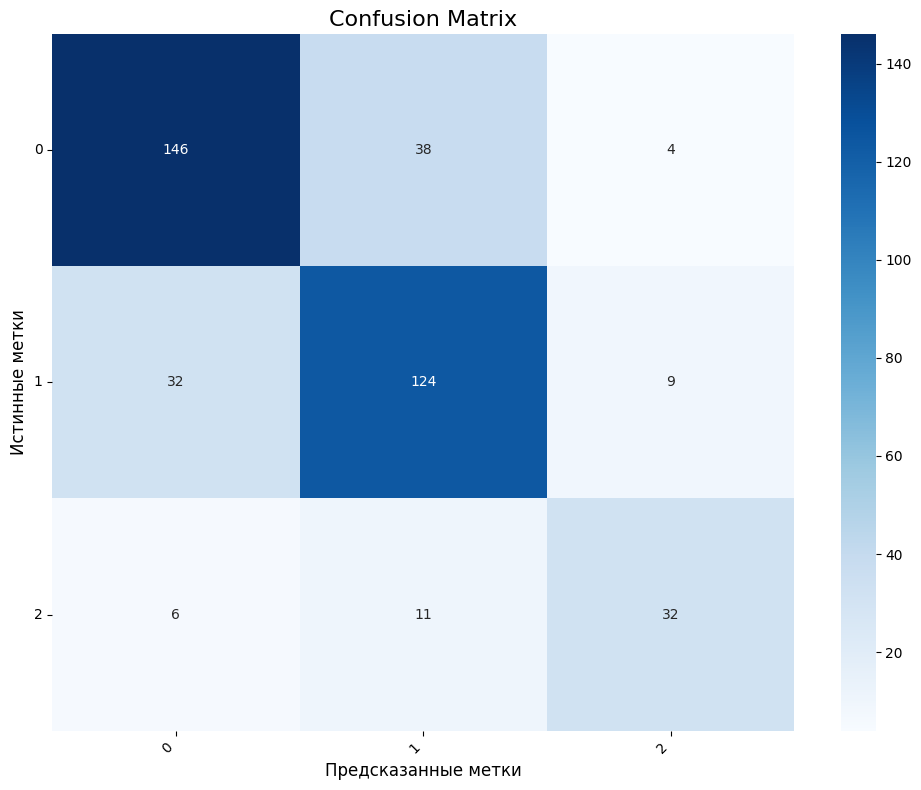

✅ Confusion Matrix сохранена в confusion_matrix.png


In [ ]:

class_names = [id2label[i] for i in sorted(id2label.keys())]

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Истинные метки', fontsize=12)
plt.xlabel('Предсказанные метки', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('./confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()